In [1]:
"""
Description:
    Project 6: Tansor Decomposition (HOSVD)

    Project for Amirkabir University of Technilogy (Tehran Polytechnic), Computer Scince department
    Computational Data-mining Course

Student Name & ID: Pouria Alimoradpor 403112088
"""

import numpy as np
from scipy.linalg import svd
import cv2
from sklearn.preprocessing import normalize

import h5py
import tkinter as tk
from PIL import Image, ImageDraw, ImageOps, ImageFilter
from matplotlib import pyplot as plt

Training set shape: (7291, 256)
Testing set shape: (2007, 256)
Each image shape: (256,)
Labels of training data: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Digit | Count 	| %
--------------------------
0     | 1194 	| 16.38%
1     | 1005 	| 13.78%
2     | 731 	| 10.03%
3     | 658 	| 9.02%
4     | 652 	| 8.94%
5     | 556 	| 7.63%
6     | 664 	| 9.11%
7     | 645 	| 8.85%
8     | 542 	| 7.43%
9     | 644 	| 8.83%


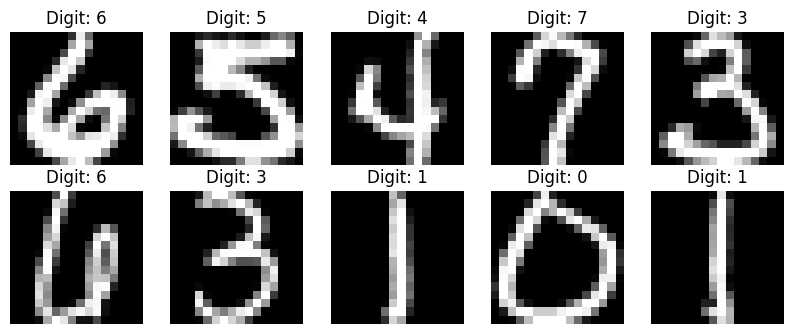

In [2]:
with h5py.File('Data/usps.h5', 'r') as hf:
    train = hf.get('train')
    X_train = train.get('data')[:]
    y_train = train.get('target')[:]
    test = hf.get('test')
    X_test = test.get('data')[:]
    y_test = test.get('target')[:]

# Print dataset infos
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)
print("Each image shape:", X_train[0].shape)
print("Labels of training data:", set(y_train))

# Print number of samples for each digit in a table-like format
print("Digit | Count \t| %")
print("--------------------------")
for digit in range(10):
    print(f"{digit}     | {np.sum(y_train == digit)} \t| {np.sum(y_train == digit) / len(y_train) * 100:.2f}%")

# Show some samples from the dataset on output
plt.figure(figsize=(10, 10))
for i in range(10):
    plt.subplot(5, 5, i + 1)
    plt.imshow(X_train[i].reshape(16, 16), cmap='gray')
    plt.title(f"Digit: {y_train[i]}")
    plt.axis('off')
plt.show()

In [3]:
# # Preprocess the data using gaussian blur
# def gaussian_blur(image, sigma=0.9):
#     blurred_image = cv2.GaussianBlur(image.reshape(16, 16), (0, 0), sigma)
#     return blurred_image.flatten()

# for i in range(len(X_train)):
#     X_train[i] = gaussian_blur(X_train[i])

# for i in range(len(X_test)):
#     X_test[i] = gaussian_blur(X_test[i])

# # Show some samples from the dataset on output
# plt.figure(figsize=(10, 10))
# for i in range(10):
#     plt.subplot(5, 5, i + 1)
#     plt.imshow(X_train[i].reshape(16, 16), cmap='gray')
#     plt.title(f"Digit: {y_train[i]}")
#     plt.axis('off')
# plt.show()

Final tensor shape: (256, 1000, 10)


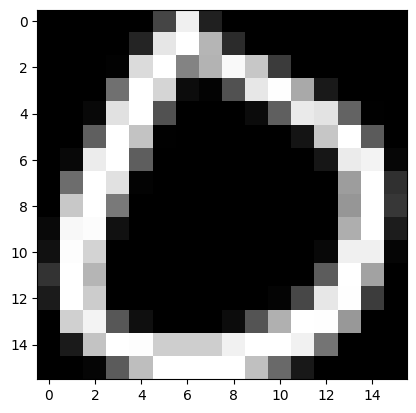

In [4]:
# Parameters
num_classes = 10           # 10 digit classes (0 to 9)
pixels_per_image = 256     # Each image is 16x16, flattened to 256
samples_per_class = 1000   # Desired number of samples per class for consistency

# Initialize empty list to hold samples of each class
class_samples = []

# Loop through each digit (0 to 9)
for digit in range(num_classes):
    # Select samples belonging to the current digit
    digit_data = X_train[y_train == digit]
    
    # If we have more samples than needed, truncate
    if len(digit_data) > samples_per_class:
        digit_data = digit_data[:samples_per_class]
    # If we have fewer samples, pad by repeating some samples
    elif len(digit_data) < samples_per_class:
        repeat_times = samples_per_class // len(digit_data) + 1
        digit_data = np.tile(digit_data, (repeat_times, 1))[:samples_per_class]
    
    # Append to the list
    class_samples.append(digit_data)

# Stack all classes along the "digit" mode to create the final tensor
tensor_data = np.stack(class_samples, axis=1)  # Shape: (1000, 10, 256)
tensor_data = tensor_data.transpose(2, 0, 1)   # Rearrange to shape: (256, 1000, 10)

print("Final tensor shape:", tensor_data.shape)

sample_100_class_3 = tensor_data[:, 0, 0].reshape(16, 16)
plt.imshow(sample_100_class_3, cmap='gray')

In [5]:
xtest = np.array([[[111, 112],
                   [121, 122],
                   [131, 132],
                   [141, 142]],
                  [[211, 212],
                   [221, 222],
                   [231, 232],
                   [241, 242]],
                  [[311, 312],
                   [321, 322],
                   [331, 332],
                   [341, 342]]])
print(xtest.shape)
print(xtest)
# xtest.reshape(-1, 2, 2)
# print(xtest.shape)
# print(xtest)
print('\n', xtest[:, 0, 0])

(3, 4, 2)
[[[111 112]
  [121 122]
  [131 132]
  [141 142]]

 [[211 212]
  [221 222]
  [231 232]
  [241 242]]

 [[311 312]
  [321 322]
  [331 332]
  [341 342]]]

 [111 211 311]


In [6]:
# Test Unfold function
def unfold_tensor(tensor, mode):
    """Unfold a tensor along a specified mode."""
    # return np.moveaxis(tensor, mode-1, 0).reshape(tensor.shape[mode-1], -1)
    if mode == 1:
        # Mode-1: Rows correspond to the first mode; flatten each frontal slice
        unfolded = np.reshape(tensor, (tensor.shape[0], -1))
        # unfolded = np.moveaxis(tensor, 0, 0).reshape(tensor.shape[0], -1)
    elif mode == 2:
        # Mode-2: Rows correspond to the second mode; rearrange to flatten across slices
        unfolded = np.reshape(np.moveaxis(tensor, 1, 0), (tensor.shape[1], -1), order='F')
    elif mode == 3:
        # Mode-3: Rows correspond to the third mode; flatten each horizontal slice
        unfolded = np.reshape(np.moveaxis(tensor, 2, 0), (tensor.shape[2], -1))
    else:
        raise ValueError("Mode should be 1, 2, or 3 for a 3-way tensor.")
    
    return unfolded


A = np.array([[[4, 0, 10],
               [2, -2, 1]],
              [[-3, 1, 5],
               [0, -1, 2]],
              [[0, 3, -1],
               [-6, 4, 4]],
              [[-1, 5, -2],
               [1, -4, 0]]])
# A = xtest
print(f'A shape: {A.shape}')
# print(A[:, :, 0])
# print(A[:, :, 1])
# print(A[:, :, 2])

# Unfold the tensor along mode 1, 2, and 3
unfolded1_tensor = unfold_tensor(A, 1)
print(f'unfold1(A) <shape {unfolded1_tensor.shape}>\n', unfolded1_tensor)
unfolded2_tensor = unfold_tensor(A, 2)
print(f'unfold2(A)<shape {unfolded2_tensor.shape}>\n', unfolded2_tensor)
unfolded3_tensor = unfold_tensor(A, 3)
print(f'unfold3(A)<shape {unfolded3_tensor.shape}>\n', unfolded3_tensor)

A shape: (4, 2, 3)
unfold1(A) <shape (4, 6)>
 [[ 4  0 10  2 -2  1]
 [-3  1  5  0 -1  2]
 [ 0  3 -1 -6  4  4]
 [-1  5 -2  1 -4  0]]
unfold2(A)<shape (2, 12)>
 [[ 4 -3  0 -1  0  1  3  5 10  5 -1 -2]
 [ 2  0 -6  1 -2 -1  4 -4  1  2  4  0]]
unfold3(A)<shape (3, 8)>
 [[ 4  2 -3  0  0 -6 -1  1]
 [ 0 -2  1 -1  3  4  5 -4]
 [10  1  5  2 -1  4 -2  0]]


In [7]:
# Test fold function
def fold_to_tensor(unfolded_tensor, mode, shape):
    """
    Folds an unfolded matrix back into a tensor of the specified shape along the specified mode.
    """
    if mode == 1:
        folded = np.reshape(unfolded_tensor, shape)
    elif mode == 2:
        folded = np.moveaxis(np.reshape(unfolded_tensor, (shape[1], shape[0], shape[2]), order='F'), 0, 1)
    elif mode == 3:
        folded = np.moveaxis(np.reshape(unfolded_tensor, (shape[2], shape[0], shape[1])), 0, 2)
    else:
        raise ValueError("Mode should be 1, 2, or 3 for a 3-way tensor.")
    
    return folded

# Test product function
def mode_n_product(tensor, x, mode):
    """Compute mode-n product of a tensor and a basis matrix."""
    result = x @ unfold_tensor(tensor, mode)
    if mode == 1:
        new_shape = (x.shape[0], tensor.shape[1], tensor.shape[2])
    elif mode == 2:
        new_shape = (tensor.shape[0], x.shape[0], tensor.shape[2])
    elif mode == 3:
        new_shape = (tensor.shape[0], tensor.shape[1], x.shape[0])
    else:
        raise ValueError("Mode should be 1, 2, or 3 for a 3-way tensor.")

    return fold_to_tensor(result, mode, new_shape)
    

A = np.array([[[1, 0, 4],
               [0, 1, 5],
               [2, 3, 0]],
              [[1, 2, 1],
               [-1, 2, 2],
               [-1, -1, -2]]])
print(A.shape)
U = np.array([[-1, 0],
              [-2, 1],
              [2, 3]])
print(U.shape)

# Compute mode-1 product of A and U
result = mode_n_product(A, U, 1)
print(f'A×1U ({result.shape})\n', result)
# print(f'A×1U[:,:,1] \n', result[:, :, 0])
# print(f'A×1U[:,:,2] \n', result[:, :, 1])
# print(f'A×1U[:,:,3] \n', result[:, :, 2])

A = np.array([[[1, 2, -3],
               [0, -1, 1]],
              [[2, 0, -1],
               [3, 1, -2]]])
print(A.shape)
V = np.array([[1, 0],
              [-2, 3],
              [4, -1]])
print(V.shape)

# Compute mode-2 product of A and U
result = mode_n_product(A, V, 2)
print(f'A×2V ({result.shape})\n', result)
# print(f'A×2V[:,:,1] \n', result[:, :, 0])
# print(f'A×2V[:,:,2] \n', result[:, :, 1])
# print(f'A×2V[:,:,3] \n', result[:, :, 2])

A = np.array([[[2, 2],
               [3, 4],
               [1, 1]],
              [[-1, -3],
               [0, 0],
               [-2, -3]]])
print(A.shape)
W = np.array([[1, 0],
              [2, -1],
              [3, 3]])
print(W.shape)

# Compute mode-3 product of A and U
result = mode_n_product(A, W, 3)
print(f'A×3W ({result.shape})\n', result)
# print(f'A×3W[:,:,1] \n', result[:, :, 0])
# print(f'A×3W[:,:,2] \n', result[:, :, 1])
# print(f'A×3W[:,:,3] \n', result[:, :, 2])

(2, 3, 3)
(3, 2)
A×1U ((3, 3, 3))
 [[[-1  0 -4]
  [ 0 -1 -5]
  [-2 -3  0]]

 [[-1  2 -7]
  [-1  0 -8]
  [-5 -7 -2]]

 [[ 5  6 11]
  [-3  8 16]
  [ 1  3 -6]]]
(2, 2, 3)
(3, 2)
A×2V ((2, 3, 3))
 [[[  1   2  -3]
  [ -2  -7   9]
  [  4   9 -13]]

 [[  2   0  -1]
  [  5   3  -4]
  [  5  -1  -2]]]
(2, 3, 2)
(3, 2)
A×3W ((2, 3, 3))
 [[[  2   2  12]
  [  3   2  21]
  [  1   1   6]]

 [[ -1   1 -12]
  [  0   0   0]
  [ -2  -1 -15]]]


In [8]:
# Test HOSVD function
def compute_basis(digit_tensor):
    """Compute HOSVD basis matrix for a digit class."""
    # SVD on each unfolding
    U1, _, _ = svd(unfold_tensor(digit_tensor, 1), full_matrices=False)
    U2, _, _ = svd(unfold_tensor(digit_tensor, 2), full_matrices=False)
    U3, _, _ = svd(unfold_tensor(digit_tensor, 3), full_matrices=False)

    S = mode_n_product(digit_tensor, U1.T, 1)
    S = mode_n_product(S, U2.T, 2)
    S = mode_n_product(S, U3.T, 3)

    # Normalize the basis matrix
    U1 = normalize(U1, axis=0)
    U2 = normalize(U2, axis=0)
    U3 = normalize(U3, axis=0)
    
    return [U1, U2, U3], S

X = np.array([[[2,2], 
               [3,4], 
               [1,1]], 
              [[-1,-3], 
               [0,0], 
               [-2,1]]])

Us, S = compute_basis(X)

Xprime = mode_n_product(S, Us[0], 1)
Xprime = mode_n_product(Xprime, Us[1], 2)
Xprime = mode_n_product(Xprime, Us[2], 3)

print(X.shape, S.shape)
print('Norm of residual:', np.linalg.norm(X - Xprime))

(2, 3, 2) (2, 3, 2)
Norm of residual: 2.52438447943028e-15


In [9]:
class HOSVDClassifier:
    """
    A classifier implementing the HOSVD (Higher-Order Singular Value Decomposition)
    algorithm for digit classification.
    
    Parameters
    ----------
    image_size : tuple, default=(16, 16)
        The dimensions to reshape the input vectors into.
    n_components : int, default=None
        Number of components to keep after SVD. If None, keep all components.
    """
    def __init__(self, image_size=(16, 16), n_components=None):
        self.image_size = image_size
        self.n_components = n_components
    
    def _unfold_tensor(self, tensor, mode):
        """Unfold a tensor along a specified mode."""
        # unfolded = np.moveaxis(tensor, mode-1, 0).reshape(tensor.shape[mode-1], -1)
        if mode == 1:
            # Mode-1: Rows correspond to the first mode; flatten each frontal slice
            unfolded = np.reshape(tensor, (tensor.shape[0], -1))
            # unfolded = np.moveaxis(tensor, mode, 0).reshape(tensor.shape[mode], -1)
        elif mode == 2:
            # Mode-2: Rows correspond to the second mode; rearrange to flatten across slices
            unfolded = np.reshape(np.moveaxis(tensor, 1, 0), (tensor.shape[1], -1), order='F')
        elif mode == 3:
            # Mode-3: Rows correspond to the third mode; flatten each horizontal slice
            unfolded = np.reshape(np.moveaxis(tensor, 2, 0), (tensor.shape[2], -1))
        else:
            raise ValueError("Mode should be 1, 2, or 3 for a 3-way tensor.")
        
        return unfolded
    
    def _fold_to_tensor(self, unfolded_tensor, mode, shape):
        """
        Folds an unfolded matrix back into a tensor of the specified shape along the specified mode.
        """
        if mode == 1:
            folded = np.reshape(unfolded_tensor, shape)
        elif mode == 2:
            folded = np.moveaxis(np.reshape(unfolded_tensor, (shape[1], shape[0], shape[2]), order='F'), 0, 1)
        elif mode == 3:
            folded = np.moveaxis(np.reshape(unfolded_tensor, (shape[2], shape[0], shape[1])), 0, 2)
        else:
            raise ValueError("Mode should be 1, 2, or 3 for a 3-way tensor.")
        
        return folded
    
    def _mode_n_product(self, tensor, x, mode):
        """Compute mode-n product of a tensor and a basis matrix."""
        # Unfold the tensor along the specified mode if it is not already unfolded
        if len(tensor.shape) == 3:
            unfolded_tensor = self._unfold_tensor(tensor, mode)
        else:
            unfolded_tensor = tensor

        # Perform matrix multiplication on the mode-n unfolded tensor
        result = x @ unfolded_tensor
        if mode == 1:
            new_shape = (x.shape[0], tensor.shape[1], tensor.shape[2])
        elif mode == 2:
            new_shape = (tensor.shape[0], x.shape[0], tensor.shape[2])
        elif mode == 3:
            new_shape = (tensor.shape[0], tensor.shape[1], x.shape[0])
        else:
            raise ValueError("Mode should be 1, 2, or 3 for a 3-way tensor.")

        return self._fold_to_tensor(result, mode, new_shape)

    def _compute_basis(self, digit_tensor):
        """Compute HOSVD basis matrix for a digit class."""
        # SVD on each unfolding
        U1, _, _ = svd(self._unfold_tensor(digit_tensor, 1), full_matrices=False)
        U2, _, _ = svd(self._unfold_tensor(digit_tensor, 2), full_matrices=False)
        U3, _, _ = svd(self._unfold_tensor(digit_tensor, 3), full_matrices=False)

        S = self._mode_n_product(digit_tensor, U1.T, 1)
        S = self._mode_n_product(S, U2.T, 2)
        S = self._mode_n_product(S, U3.T, 3)

        # Keep only the first n_components
        if self.n_components is not None:
            U1 = U1[:, :self.n_components]
            U2 = U2[:, :self.n_components]
            U3 = U3[:, :self.n_components]
            S = S[:self.n_components, :self.n_components, :]

        # Normalize the basis matrix
        U1 = normalize(U1, axis=0)
        U2 = normalize(U2, axis=0)
        U3 = normalize(U3, axis=0)
        
        return [U1, U2, U3], S
        
    def fit(self, X, y):
        """Fit the HOSVD classifier."""
        self.classes_ = np.unique(y) # Unique classes
        self.basis_ = self._compute_basis(X) # Compute bases
        
        return self
    
    def _compute_residual(self, digit_matrix, basis):
        """Compute residual between a digit tensor and its basis."""
        # print('digit_matrix Shape:', digit_matrix.shape)
        [U, V, W], S = basis
        # print('S Shape:', S.shape)
        # print('U Shape:', U.shape)
        # print('V Shape:', V.shape)
        # print('W Shape:', W.shape)
        C = self._mode_n_product(self._mode_n_product(S, U, 1), V, 2)
        # print('C Shape:', C.shape)
        C_pseudo_inv = np.stack([np.linalg.pinv(C[:, i, :]) 
                                 for i in range(C.shape[1])], axis=1)
        # print('C_pseudo_inv Shape:', C_pseudo_inv.shape)
        projected_tensor = C_pseudo_inv @ digit_matrix # self._mode_n_product(C_pseudo_inv, digit_matrix, 3)
        # print('projected_tensor Shape:', projected_tensor.shape)

        residual = np.linalg.norm(W[:, :, np.newaxis] - projected_tensor, ord=2, axis=1)
        # print('residual Shape:', residual.shape)
        return residual

    def predict(self, X):
        """Predict digit classes for samples in X."""
        # Make predictions
        predictions = []
        for i, x in enumerate(X):
            # Compute residuals for each class
            residual = self._compute_residual(x, self.basis_)
            # Predict class with minimum residual
            min_index = np.unravel_index(np.argmin(residual), residual.shape)
            # print('min_index:', min_index)
            pred = self.classes_[min_index[0]]
            predictions.append(pred)
            # Show progress bar
            progress = (i + 1) / len(X) * 100
            bar_length = 10
            filled_length = int(bar_length * progress // 100)
            bar = '◼' * filled_length + '◻' * (bar_length - filled_length)
            print(f'\r[{bar}] {progress:.2f}%', end='', flush=True)
        
        return np.array(predictions)
    
    def __repr__(self):
        return f"HOSVDClassifier(image_size={self.image_size}, n_components={self.n_components})"

In [10]:
# Train classifier
hosvd = HOSVDClassifier(n_components=64) # 
hosvd.fit(tensor_data, y_train)

HOSVDClassifier(image_size=(16, 16), n_components=64)

In [11]:
# Test classifier
y_pred = hosvd.predict(X_test)
accuracy = np.mean(y_pred == y_test)
print(f"\nAccuracy: {accuracy:.3f}")

[◼◼◼◼◼◼◼◼◼◼] 100.00%
Accuracy: 0.903


In [ ]:
# Find optimal number of components
n_components = np.arange(16, 100)
accuracies = []
for n in n_components:
    hosvd = HOSVDClassifier(n_components=n)
    hosvd.fit(X_train, y_train)
    y_pred = hosvd.predict(X_test)
    accuracy = np.mean(y_pred == y_test)
    accuracies.append(accuracy)

# Return the best number of components between normalized and non-normalized data
best_n_components = n_components[np.argmax(accuracies)]
print(f"Best number of components for normalized data: {best_n_components}, Accuracy: {accuracies[np.argmax(accuracies)]:.3f}")

# Plot accuracy vs. number of components
plt.figure(figsize=(10, 6))
plt.plot(n_components, accuracies, label="Normalized data")
plt.xlabel("Number of components")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Number of Components")
plt.legend()
plt.grid()
plt.show()

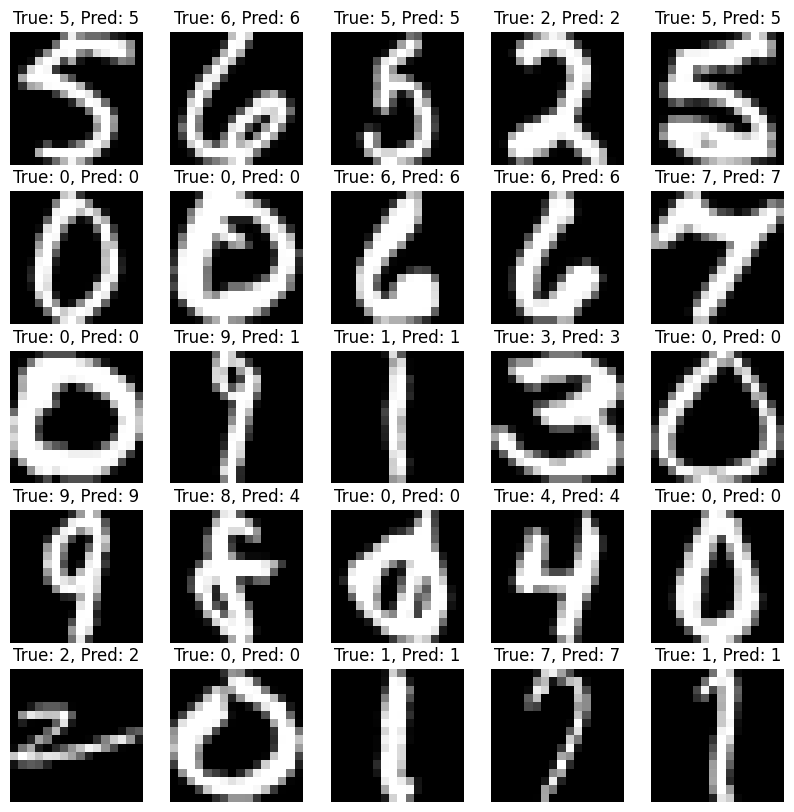

In [13]:
# Show random samples from the test set with their predictions
plt.figure(figsize=(10, 10))
for i in range(25):
    idx = np.random.randint(len(X_test))
    plt.subplot(5, 5, i + 1)
    plt.imshow(X_test[idx].reshape(16, 16), cmap='gray')
    plt.title(f"True: {y_test[idx]}, Pred: {y_pred[idx]}")
    plt.axis('off')

[◼◼◼◼◼◼◼◼◼◼] 100.00%

C:\Users\porip\AppData\Local\Temp\ipykernel_33300\2437484791.py:62: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(3, 3))


[◼◼◼◼◼◼◼◼◼◼] 100.00%

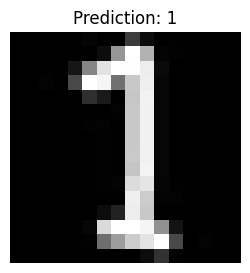

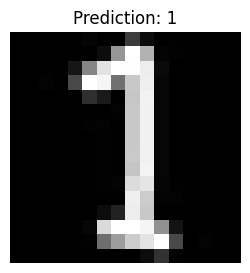

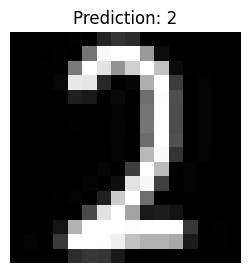

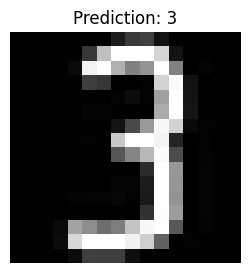

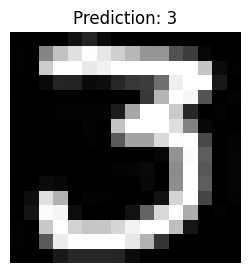

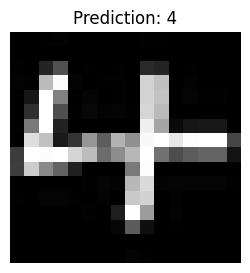

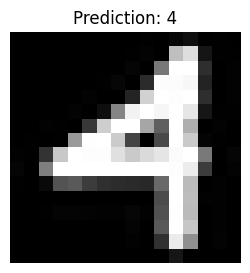

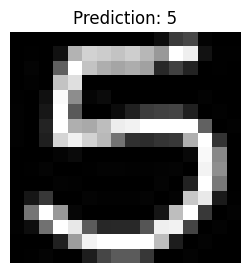

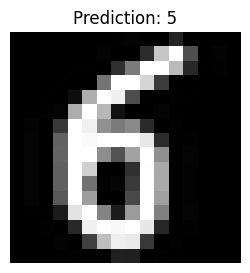

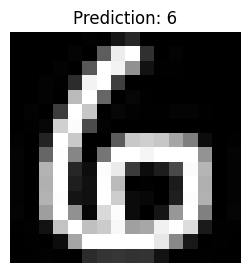

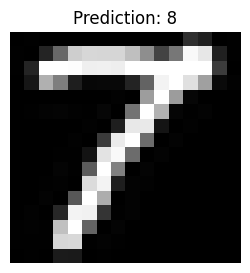

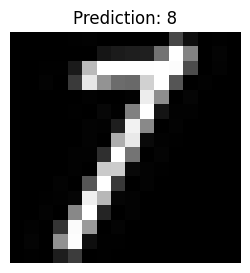

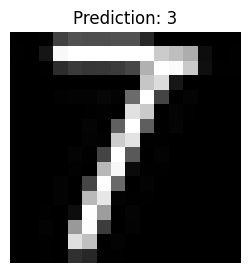

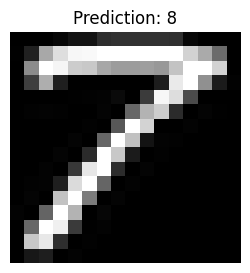

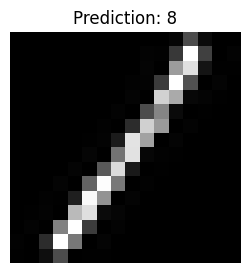

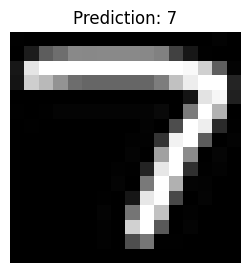

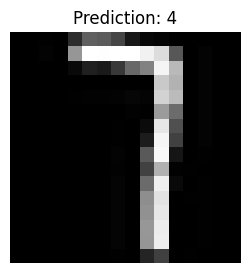

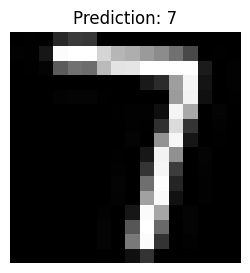

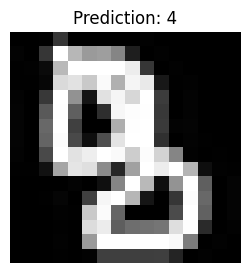

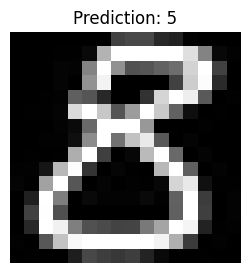

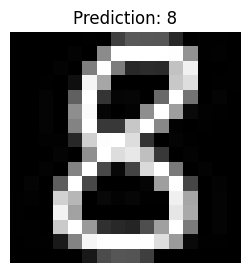

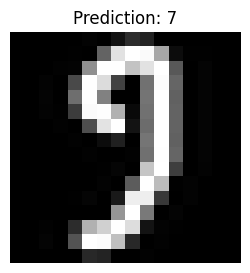

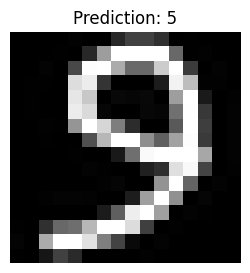

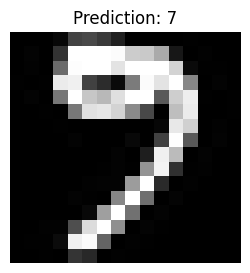

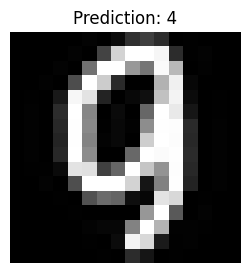

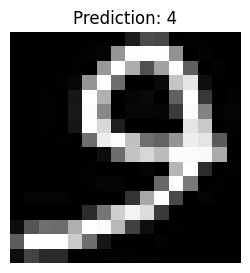

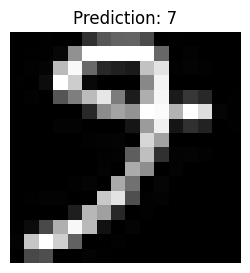

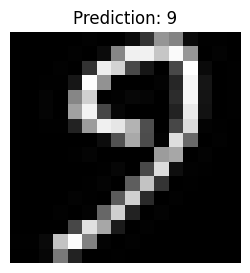

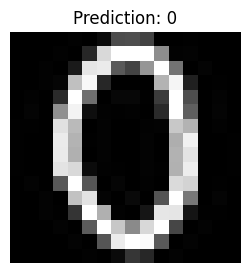

In [41]:
class DigitRecognizerApp:
    def __init__(self, master):
        self.master = master
        self.master.title("Digit Recognizer")

        self.canvas = tk.Canvas(self.master, width=160, height=160, bg='white')
        self.master.resizable(False, False)
        self.canvas.grid(row=0, column=0, pady=4, padx=4)
        self.canvas.bind("<B1-Motion>", self.paint)

        self.btn_clear = tk.Button(master, text="Clear", command=self.clear_canvas, width=10)
        self.btn_clear.grid(row=1, column=0, pady=10, padx=10, sticky='w')

        self.btn_submit = tk.Button(master, text="Submit", command=self.predict_digit, width=10, bg='blue', fg='white')
        self.btn_submit.grid(row=1, column=0, pady=10, padx=10, sticky='e')
        
        self.prediction_text = tk.StringVar()
        self.label = tk.Label(master, textvariable=self.prediction_text, font=("Helvetica", 18))
        self.label.grid(row=3, column=0, pady=2)
        
        self.image = Image.new("L", (200, 200), color=255)
        self.draw = ImageDraw.Draw(self.image)

    def paint(self, event):
        x, y = event.x, event.y
        r = 5
        self.canvas.create_oval(x-r, y-r, x+r, y+r, fill='black')
        self.draw.ellipse([x-r, y-r, x+r, y+r], fill='black')

    def clear_canvas(self):
        self.canvas.delete("all")
        self.image = Image.new("L", (200, 200), color=255)
        self.draw = ImageDraw.Draw(self.image)
        self.prediction_text.set("")

    def predict_digit(self):
        # Crop the image to remove black space borders and only keep the digit
        inverted_image = ImageOps.invert(self.image)
        bbox = inverted_image.getbbox()
        # Calculate maximum bounding box to crop like square without distorting the image
        max_dim = max(bbox[2] - bbox[0], bbox[3] - bbox[1])
        if bbox[2] - bbox[0] < max_dim:
            diff = max_dim - (bbox[2] - bbox[0])
            bbox = (bbox[0] - diff // 2, bbox[1], bbox[2] + diff // 2, bbox[3])
        if bbox[3] - bbox[1] < max_dim:
            diff = max_dim - (bbox[3] - bbox[1])
            bbox = (bbox[0], bbox[1] - diff // 2, bbox[2], bbox[3] + diff // 2)
        
        # Uncrop 5 pixels from each side
        bbox = (max(bbox[0] - 5, 0), max(bbox[1] - 5, 0), min(bbox[2] + 5, self.image.width), min(bbox[3] + 5, self.image.height))
        
        cropped_image = self.image.crop(bbox)
        self.image = cropped_image
        img_resized = self.image.resize((16, 16), Image.LANCZOS)
        img_inverted = ImageOps.invert(img_resized)
        img_array = np.array(img_inverted) / 255.0
        img_flatten = img_array.flatten().reshape(16, 16)

        prediction = hosvd.predict(img_flatten.flatten().reshape(1, -1))[0]
        self.prediction_text.set(f"Prediction: {prediction}")

        plt.figure(figsize=(3, 3))
        plt.axis('off')
        plt.title(f"Prediction: {prediction}")
        plt.imshow(img_flatten, cmap='gray')

root = tk.Tk()
app = DigitRecognizerApp(root)
root.mainloop()